In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
def load_npy(filename):
    return np.load(filename)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/DM2/dataset/time_series/'
len_threshold = 1280

In [ ]:
X, y, ids = [], [], []

for file in os.listdir(dir_path):
    if os.path.splitext(file)[1] != '.npy':
        continue

    split = file.split("_")
    ids.append(split[0]) # track_id
    y.append(split[1][:-4]) # genre
    ts = load_npy(dir_path + file)

    if len(ts) > len_threshold:
        ts = ts[0:len_threshold]
    else:
        # pad = [np.mean(ts[:-5])] * (len_threshold-len(ts)) # fill by mean value of last n observations
        pad = [ts[-1]] * (len_threshold-len(ts)) # fill with last observation
        ts = np.append(ts, pad)

    X.append([ts])

X, y, ids = np.array(X), np.array(y), np.array(ids)

In [ ]:
# prompt: Convert y to dataframe

import pandas as pd
y_df = pd.DataFrame(y, columns=['genre'])


In [ ]:
# Assuming TimeSeriesDatay_df is your DataFrame and the genres are in a column named 'genre'
# Replace 'genre' with the actual column name if it's different

genres_to_correct = np.array(['progressive-house', 'mpb', 'mpb (1)', 'opera', 'songwriter',
       'j-idol', 'minimal-techno', 'happy', 'synth-pop', 'new-age',
       'new-age (1)', 'heavy-metal', 'kids', 'goth', 'emo', 'emo (1)',
       'salsa', 'piano', 'piano (1)', 'honky-tonk', 'folk', 'sleep',
       'world-music', 'sertanejo', 'sertanejo (1)', 'folk (1)'],
      dtype=object)


def correct_genre(genre):
    if genre == "mpb (1)":
      return "mpb"
    elif genre == "new-age (1)":
      return "new-age"
    elif genre == "emo (1)":
      return "emo"
    elif genre == "piano (1)":
      return "piano"
    elif genre == "sertanejo (1)":
      return "sertanejo"
    elif genre == "folk (1)":
      return "folk"
    else:
      return genre


y_df["genre"] = y_df["genre"].apply(correct_genre)

In [ ]:
from sklearn.preprocessing import LabelEncoder # import LabelEncoder to encode string labels

y = LabelEncoder().fit_transform(y_df["genre"])

In [ ]:
from sklearn.model_selection import train_test_split # Import the necessary function

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6118, 1, 1280), (1530, 1, 1280), (6118,), (1530,))

In [ ]:
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
df_paa=pd.read_csv('/content/drive/MyDrive/DM2/dataset/paa_features.csv')

In [ ]:
x_paa=df_paa.iloc[:,:70]

In [ ]:
# prompt: reshape x_paa to 3D like this: (7648, 1, 1280)

x_paa = x_paa.values.reshape(7648, 1, 70)

In [ ]:
from sklearn.model_selection import train_test_split # Import the necessary function

X_train, X_test, y_train, y_test = train_test_split(
    x_paa, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6118, 1, 70), (1530, 1, 70), (6118,), (1530,))

In [ ]:
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = TabularToSeriesAdaptor(MinMaxScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  If False and the attribute exists, then check that it is equal to
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Please implement the `__sklearn_tags__` method.
  If False and the attribute exists, then check that it is equal to
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:411: FutureWarning: The `_get_tags` method is deprecated in 1.6 and will be removed in 1.7. Pleas

In [ ]:
#from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

In [ ]:
rst = RandomShapeletTransform(n_shapelet_samples=100, max_shapelets=None, min_shapelet_length=3, max_shapelet_length=None, n_jobs=-1) #n_jobs -1 uses all processors

In [ ]:
rst.fit(X_train_scaled, y_train)

RandomShapeletTransform(n_jobs=-1, n_shapelet_samples=100)

In [ ]:
%%time
shapelets_distances_train = rst.transform(X_train_scaled)
shapelets_distances_test = rst.transform(X_test_scaled)

CPU times: user 1min 22s, sys: 14.8 s, total: 1min 37s
Wall time: 1min 59s


In [ ]:
X_test_scaled.shape

(1530, 1, 70)

In [ ]:
y_test.shape

(1530,)

In [ ]:
# prompt: export shapelets_distances_train, shapelets_distances_test, scaled X and y to csv in the same folder as track dataset.

import pandas as pd
import os

# Assuming 'dir_path' is defined as in your previous code
dir_path = '/content/drive/MyDrive/DM2/dataset/'

# Exporting to CSV files
pd.DataFrame(shapelets_distances_train).to_csv(os.path.join(dir_path, 'shapelets_distances_train.csv'), index=False)
pd.DataFrame(shapelets_distances_test).to_csv(os.path.join(dir_path, 'shapelets_distances_test.csv'), index=False)
pd.DataFrame(X_train_scaled.reshape(X_train_scaled.shape[0], -1)).to_csv(os.path.join(dir_path, 'X_train_scaled.csv'), index=False) # Reshape if necessary
pd.DataFrame(X_test_scaled.reshape(X_test_scaled.shape[0], -1)).to_csv(os.path.join(dir_path, 'X_test_scaled.csv'), index=False) # Reshape if necessary
pd.DataFrame(y_train).to_csv(os.path.join(dir_path, 'y_train.csv'), index=False)
pd.DataFrame(y_test).to_csv(os.path.join(dir_path, 'y_test.csv'), index=False)

In [ ]:
shapelets_distances_train.shape

(6118, 100)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform

TypeError: C function sklearn.tree._utils.__pyx_fuse_2safe_realloc has wrong signature (expected int (unsigned char **, size_t), got int (__pyx_t_7sklearn_5utils_9_typedefs_uint8_t **, size_t))

In [ ]:

clf = DecisionTreeClassifier()
clf = clf.fit(shapelets_distances_train, y_train)
y_pred = clf.predict(shapelets_distances_test)
print(classification_report(y_test, y_pred))

TypeError: C function sklearn.tree._utils.__pyx_fuse_2safe_realloc has wrong signature (expected int (unsigned char **, size_t), got int (__pyx_t_7sklearn_5utils_9_typedefs_uint8_t **, size_t))

In [ ]:
# Each item in the list is a tuple containing the following 7 items:
# (shapelet information gain, shapelet length, start position the shapelet was extracted from,
# shapelet dimension, index of the instance the shapelet was extracted from in fit,
# class value of the shapelet, The z-normalised shapelet array)
shapelets = rst.shapelets
shapelets[0]

(0.01974070193,
 61,
 6,
 0,
 8,
 12,
 array([-1.11604524e+00, -6.51012005e-01, -5.67493646e-01,  8.61787694e-01,
        -5.11114141e-01,  1.27269204e-01,  3.98011016e-01, -1.33014096e-01,
        -3.64693988e-01, -7.41735736e-01, -2.59853399e-01, -4.84787574e-01,
        -1.36471733e-03, -5.71873935e-01, -5.14337861e-01, -3.20288107e-01,
         1.69191696e-01,  5.01824351e-01, -6.76681605e-01, -5.83795468e-01,
        -4.85443162e-01, -1.06586344e+00, -1.16102334e+00,  1.00098511e-01,
        -8.68217787e-01, -5.02736363e-01,  1.87478260e-01, -1.37232244e+00,
        -2.12613922e+00, -2.26226542e+00, -1.91347293e+00, -1.64528886e+00,
        -7.33951721e-01, -8.07845044e-01, -5.21132788e-01, -2.20768019e-01,
        -8.12188234e-01, -4.24878176e-01, -4.92074265e-01, -1.17808592e-02,
         2.66670461e+00,  2.22545879e+00,  1.07181346e+00,  1.11425274e+00,
         1.61514511e+00,  9.48489234e-01,  9.66821619e-01,  1.08343890e+00,
         1.10427176e+00,  1.10717339e+00,  4.70061

In [ ]:
plt.plot(shapelets[i][6])
  plt.show()

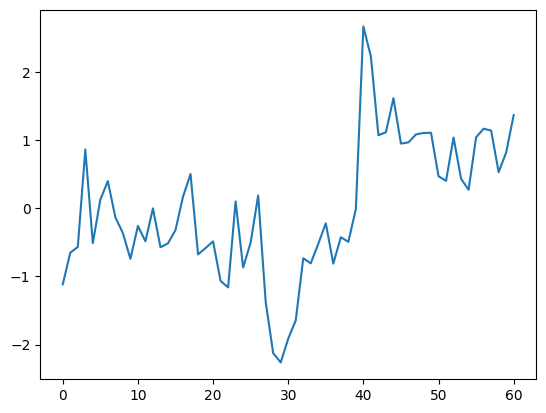

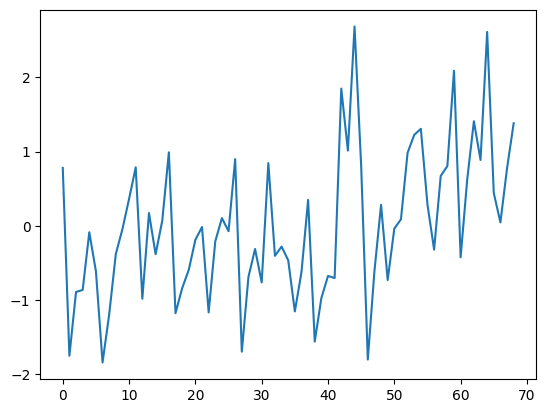

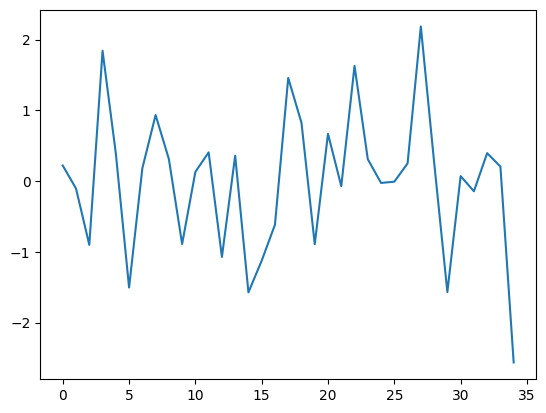

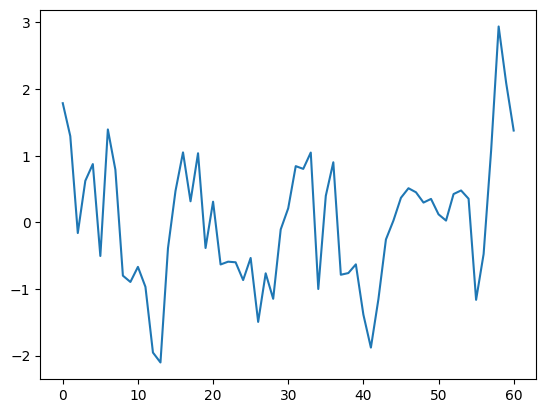

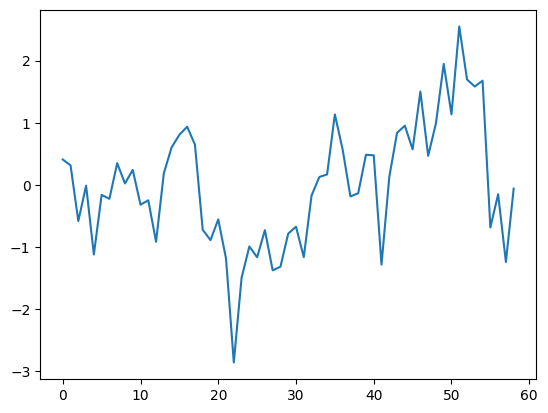

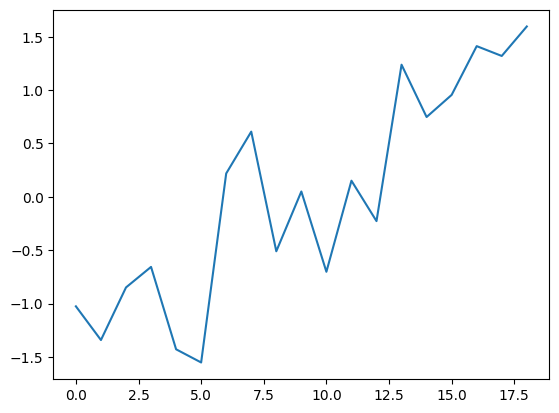

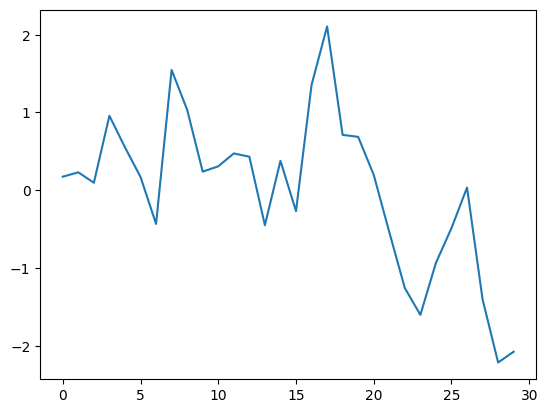

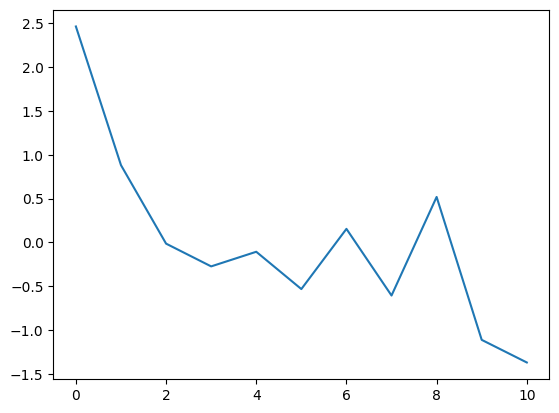

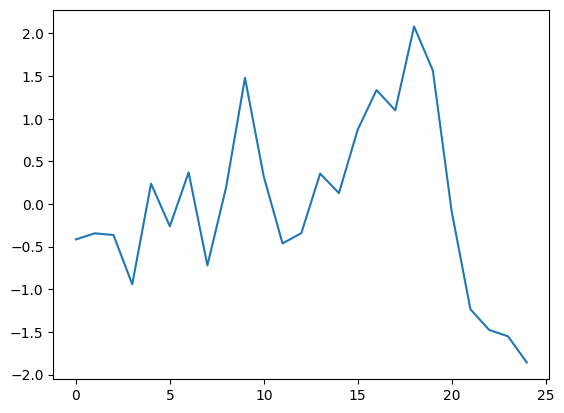

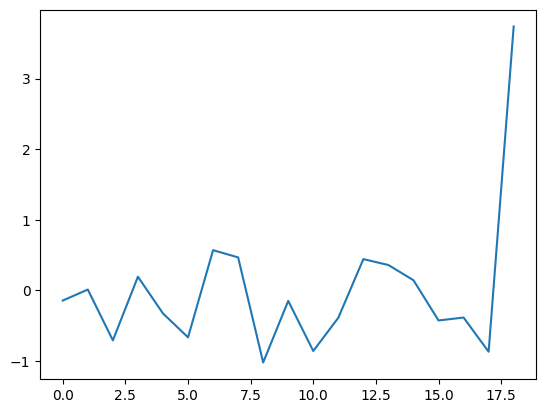

In [ ]:
# plotting the z-normalized shapelet arrays
import matplotlib.pyplot as plt # Import the necessary module
for i in range(10):
  plt.plot(shapelets[i][6])
  plt.show()

In [ ]:
sh_id = 21
start_position = shapelets[sh_id][2]
instance_index = shapelets[sh_id][4]
z_norm_shapelet = shapelets[sh_id][6]
end_position = start_position + len(z_norm_shapelet)

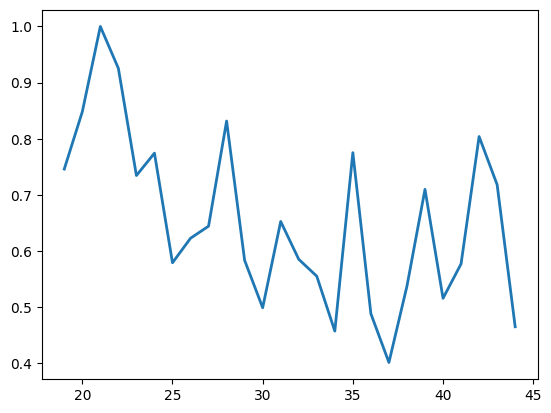

In [ ]:
plt.plot(np.arange(start_position, end_position), X_train_scaled[instance_index].ravel()[start_position:end_position], linewidth=2, label='shapelet')
plt.show()

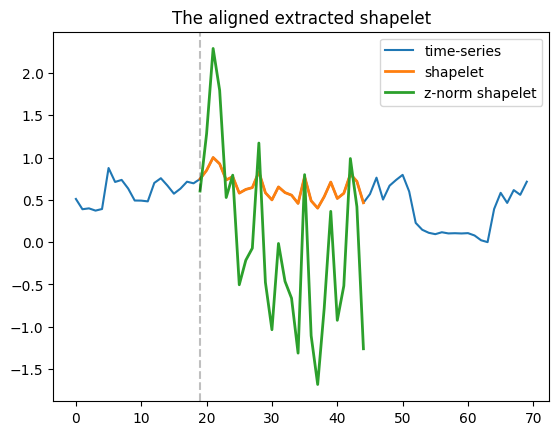

In [ ]:
plt.plot(X_train_scaled[instance_index].ravel(), label='time-series')
plt.plot(np.arange(start_position, end_position), X_train_scaled[instance_index].ravel()[start_position:end_position], linewidth=2, label='shapelet')
plt.plot(np.arange(start_position, end_position), z_norm_shapelet, linewidth=2, label='z-norm shapelet')
plt.axvline(start_position, color='k', linestyle='--', alpha=0.25)
plt.title("The aligned extracted shapelet")
plt.legend()
plt.show()

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 36.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 12.2.0 requires numpy<1.27,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
langchain 0.3.12 requires numpy<2,>=1.22.4; python_version < "3.12", but you have numpy 2.0.2 which is incompatible.
matplotlib 3.8.0 requires numpy<2,>=1.21, but you have numpy 2.0.2 which is incompatible.
pytensor 2.26.4 requires numpy<2,>=1.17.0, bu

In [ ]:
from tensorflow.keras.optimizers import Adam
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict

TypeError: C function sklearn.tree._utils.__pyx_fuse_2safe_realloc has wrong signature (expected int (unsigned char **, size_t), got int (__pyx_t_7sklearn_5utils_9_typedefs_uint8_t **, size_t))